In [283]:
import cv2
import os
import math
import random
import glob
import sys
import numpy as np 
from PIL import Image

### 이미지 분할

In [347]:
image_path = "image/origin.jpeg"
# mat -> [col, row]
cols, rows = 2, 2

In [332]:
# 이미지 로드
img = cv2.imread(image_path)
# 이미지 해상도 확인 
h, w = img.shape[:2]
#print(h,w)
# 이미지 분할 -> 입력받은 매트릭 개로 분할
# 가로, 세로 크기 계산
crop_h = (h/row if (h/row).is_integer() else math.trunc(h/row))
crop_w = (w/col if (w/col).is_integer() else math.trunc(w/col))
#print(crop_h, crop_w)

# col by row 이미지 자르기
cropped_images = []

for i in range(row):
    for j in range(col):
        left = int(j * crop_w)
        top = int(i * crop_h)
        right = int((j + 1) * crop_w)
        bottom = int((i + 1) * crop_h)
        #print(f"left:{left}, top:{top}, right:{right}, bottom:{bottom}")
        cropped_image = img[top:bottom, left:right]
        
# 분할된 이미가 각 50%의 확률로 미러링, 플립핑, 90도 변환이 되록하여 아웃풋 이미지들을 만들어 낸뒤 저장

        # mirroring (좌우)
        if random.random() > 0.5:
            cropped_image = cv2.flip(cropped_image, 1)
            #print("mirroring is done")
        # flipping (상하)
        if random.random() > 0.5:
            cropped_image = cv2.flip(cropped_image, 0)
            #print("flipping is done")
        # 90도변환
        if random.random() > 0.5:
            cropped_image = cv2.rotate(cropped_image, cv2.ROTATE_90_CLOCKWISE)
            #print("rotatind is done")
        
        cropped_images.append(cropped_image)
 


# 이미지 저장 -> 정보를 알 수 없게 
if not os.path.exists("image/crooped_images/"):
    os.mkdir("image/crooped_images/")
else:
    [os.remove(f) for f in glob.glob("image/crooped_images/*.jpg")]
    
for img in cropped_images:
    cv2.imwrite(f"image/crooped_images/cropped_{int(round(random.random(),7) * 10000000)}.jpg", img)


### 이미지 병합 

In [333]:
cropped_img_f = glob.glob("image/crooped_images/*.jpg")
cropped_images = [cv2.imread(i) for i in cropped_img_f]
print(len(cropped_images))

4


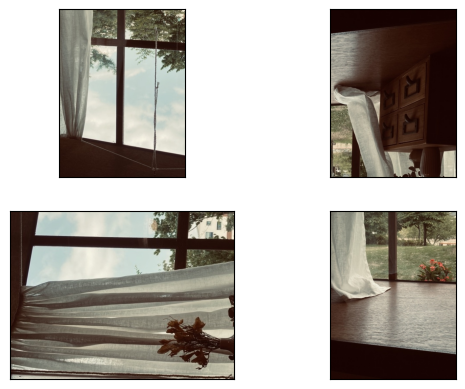

In [334]:
# 분할된 이미지를 확인하기 위한 코드
import matplotlib.pyplot as plt

fig = plt.figure()
idx = 1
for i in range(len(cropped_images)):
    ax = fig.add_subplot(row, col, idx)
    ax.imshow(cv2.cvtColor(cropped_images[i], cv2.COLOR_BGR2RGB))
    ax.set_xticks([])
    ax.set_yticks([])
    idx +=1
    
plt.show()

In [335]:
stitcher = cv2.Stitcher_create()
ret, dst = stitcher.stitch(cropped_images)

if ret != cv2.Stitcher_OK:
    print('Stitch failed')
    sys.exit()
    
    
plt.imshow(dst)

Stitch failed


SystemExit: 

/Users/haram/anaconda3/envs/test/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3513: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


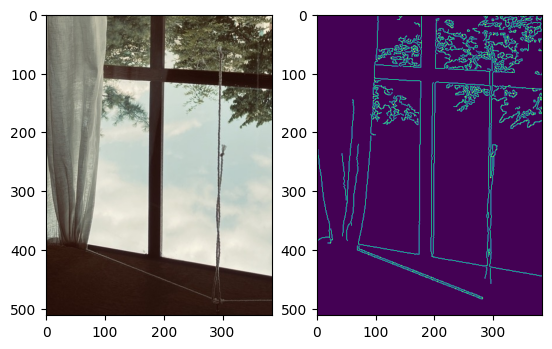

In [336]:
# edge detection test
img_1 = cropped_images[0]
img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)

dst = cv2.GaussianBlur(img_1, (0,0), 1)
canny = cv2.Canny(dst, 60,200)

fig, axes = plt.subplots(1,2)
axes[0].imshow(img_1)
axes[1].imshow(canny)

    
plt.show()

In [337]:
for i in cropped_images:
    print(f"img1 shape {i.shape[:2]}")

# col, row 는 입력을 받음 
cols = 2
rows = 1

origin_d = (np.max(i.shape[:2]) * np.min([cols, rows]), np.min(i.shape[:2]) * np.max([cols, rows]))
print(origin_d)


img1 shape (512, 384)
img1 shape (512, 384)
img1 shape (384, 512)
img1 shape (512, 384)
(512, 768)


In [338]:
res_set = []
for idx, img in enumerate(cropped_images):
    if idx == 0:
        stan_img_shape = img.shape[:2]
        print(stan_img_shape)
        res_set.append(img)
    else:
        if stan_img_shape == img.shape[:2]:
            print("ok")
            res_set.append(img)
        else:
            sub_img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
            print(sub_img.shape[:2])
            res_set.append(sub_img)
            

(512, 384)
ok
(512, 384)
ok


In [340]:
# Edge Detection
# edge detection test
detect_img = []
for img in cropped_images:
    
    cvt_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # GaussianBlur
    blur_img = cv2.GaussianBlur(cvt_img, (0,0), 1)
    # Canny Detection
    canny_img = cv2.Canny(blur_img, 60,200)
    # line detection
    try:
        lines = cv2.HoughLines(canny_img, 0.8, np.pi/180, 150, srn = 100, stn = 200, min_theta = 0, max_theta = np.pi)

        for i in lines:
            rho, theta = i[0][0], i[0][1]
            #print(rho, theta)
            a, b = np.cos(theta), np.sin(theta)
            #print(a,b)
            x0, y0 = a * rho, b * rho
            
            scale = cvt_img.shape[0] + cvt_img.shape[1]
            
            x1 = int(x0 + scale * -b)
            y1 = int(y0 + scale * a)
            x2 = int(x0 - scale * -b)
            y2 = int(y0 - scale * a)
            
            cv2.line(cvt_img, (x1,y1), (x2, y2), (0,0,255),2)
            cv2.circle(cvt_img, (int(x0), int(y0)), 3, (255,0,0), 5, cv2.FILLED)
            
        detect_img.append([cvt_img, canny_img])
    except:
        print("linde detection failed")    

linde detection failed
linde detection failed


In [350]:
background = np.zeros(origin_d)
background.shape[:2]
copy_img = res_set.copy()
img_idx = 0
for i in range(cols):
    for j in range(rows):
        if rows != 1:
            merge_img = cv2.vconcat(copy_img[:2])
            copy_img.pop(0)
            print(len(copy_img))
    if cols != 1:
        merge_img = cv2.hconcat(copy_img[:2])
        copy_img.pop(0)
        print(len(copy_img))
                        

3
2
1
0


IndexError: pop from empty list

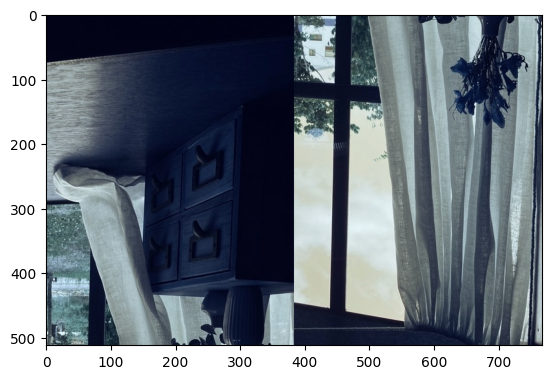

In [344]:
plt.imshow(merge_img)

In [316]:
t1 = res_set[0].copy()
t2 = res_set[1].copy()

In [320]:
c_img = cv2.hconcat([t1,t2])

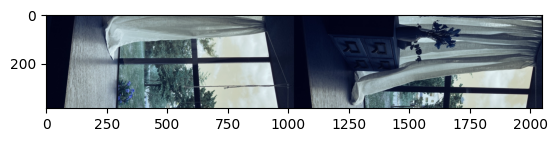